# Regression Analysis Cultura Data

This notebook provides an overview of the statistical analysis that complements the main results in our paper. We primarily aim to test the hypothesis that the cultural production score can serve as a proxy for GDP. To evaluate this proposition, we use regression models where GDP is the dependent variable, and cultural production is one of the independent variables. We employ Bayesian Regression Modeling with Bambi—built upon PyMC—for a robust assessment of the correlation between these two variables. But before we delve into the models, we will first load and normalize the data to streamline the processing.

## Data Preparation

In [1]:
import pandas as pd
import numpy as np
import bambi as bmb
import arviz as az

df = pd.read_csv("data_stats_filtered.csv", index_col=0)
df["region_name_id"] = pd.factorize(df["region_name"])[0]
print(f"N = {df.shape[0]}")
df.sample(5)

N = 3228


,year,region_name,population_interpolated,N_est,lower,upper,score,score_cap,lower_cap,N_est_cap,upper_cap,gdp_per_capita,inclusive,restricted,region_name_id
343,1705,Eastern Europe,17.650,4923.956159,4396.652371,5462.343917,207.0,11.752057,249.887725,279.865753,310.469330,983,1,1,1
1431,1732,Italy,14.280,6756.287917,6142.478376,7385.878053,355.0,24.839861,429.720025,472.668839,516.719050,2911,1,1,4
1158,1459,Italy,8.770,1551.140678,1398.528159,1713.723518,180.2,20.553877,159.642588,177.064224,195.624496,3495,1,1,4
639,1449,France,12.960,791.472479,678.762875,914.866272,55.5,4.272894,52.250080,60.926480,70.425352,1812,1,1,2
2238,1499,Nordic countries,1.455,195.898661,145.232707,252.748654,15.0,10.288546,99.547197,134.276373,173.244378,1417,1,1,7


We have GDP data for the following 10 regions:

In [2]:
df["region_name"].value_counts()

United Kingdom      590
Nordic countries    541
France              532
Italy               532
Low countries       487
Eastern Europe      423
Spain                58
Chinese world        46
Japan                12
German world          7
Name: region_name, dtype: int64

We apply a logarithmic transformation to the GDP to account for its exponential growth, as our interest lies in variables that maintain a linear correlation with GDP. We also center this at 1, which aids in straightforward interpretation. We employ the same strategy to both the production score (`score`) and the bias-corrected production score (`N_est`):

In [3]:
# Apply normalization

df["century"] = df["year"].round(-2)
df["score_log"] = np.log(df["score"])
df["score_cap_log"] = np.log(df["score_cap"])
df["N_est_log"] = np.log(df["N_est"])
df["N_est_cap_log"] = np.log(df["N_est_cap"])
df["score_log_std"] = df["score_log"] / df["score_log"].mean()
df["score_cap_log_std"] = np.log(df["score_cap"]) / df["score_cap_log"].mean()
df["N_est_log_std"] = df["N_est_log"] / df["N_est_log"].mean()
df["N_est_cap_log_std"] = np.log(df["N_est_cap"]) / df["N_est_cap_log"].mean()
df["log_gdp"] = np.log(df["gdp_per_capita"])
df["log_gdp_std"] = df["log_gdp"] / df["log_gdp"].mean()
df.sample(5)

,year,region_name,population_interpolated,N_est,lower,upper,score,score_cap,lower_cap,N_est_cap,...,score_log,score_cap_log,N_est_log,N_est_cap_log,score_log_std,score_cap_log_std,N_est_log_std,N_est_cap_log_std,log_gdp,log_gdp_std
556,1366,France,12.700,76.625332,62.668893,91.609595,6.6,0.516923,4.921207,6.016846,...,1.887070,-0.659861,4.338928,1.794563,0.436278,-0.273852,0.641885,0.370475,7.529943,1.002683
2249,1510,Nordic countries,1.489,99.987300,74.787175,128.287845,10.0,6.715917,50.226444,67.150638,...,2.302585,1.904480,4.605043,4.206938,0.532342,0.790387,0.681253,0.868493,7.720905,1.028111
1359,1660,Italy,11.400,4696.293894,4287.210643,5102.189225,286.0,25.087719,376.071109,411.955605,...,5.655992,3.222378,8.454529,6.020916,1.307626,1.337334,1.250731,1.242976,7.870548,1.048038
1499,1800,Italy,19.000,14904.596439,13754.155537,16082.042807,725.0,38.157895,723.902923,784.452444,...,6.586172,3.641733,9.609425,6.664986,1.522678,1.511372,1.421582,1.375940,7.784889,1.036631
818,1628,France,19.900,2124.964856,1960.978405,2295.817479,213.8,10.754872,98.633432,106.883497,...,5.365041,2.375359,7.661511,4.671739,1.240361,0.985808,1.133415,0.964448,7.404279,0.985950


The distribution of the logged GDP values is clearly trimodal:

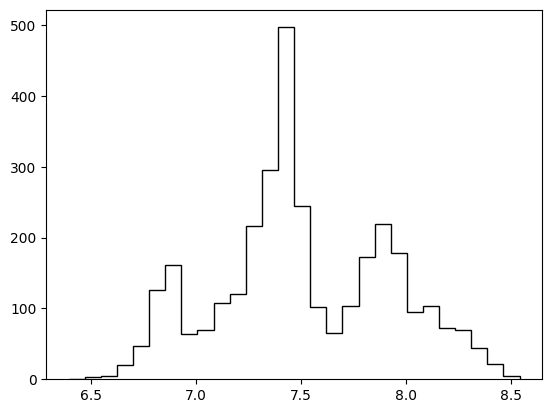

In [4]:
import matplotlib.pyplot as plt

plt.hist(df["log_gdp"].values, histtype="step", color="k", bins="fd");

We observe an intriguing trimodal structure. It was suggested by Charles that this might be due to "the fact that the Maddison data always tend to have an estimation for a region at date year=1 and then jump up to over year=1000". Filtering these instances, doesn't seem to alter the trimodal structure, however:

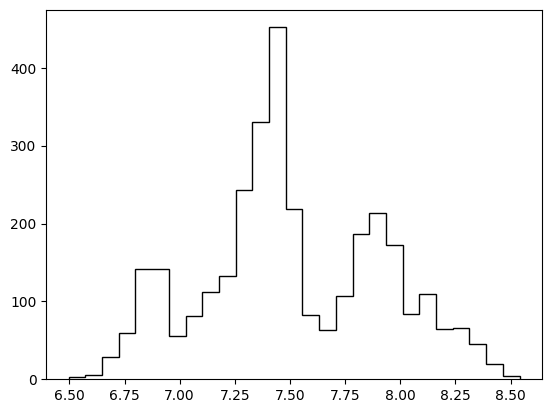

In [5]:
plt.hist(df.loc[df["year"] >= 1000, "log_gdp"].values, histtype="step", color="k", bins="fd");

The trimodality of the data is somewhat hidden when plotting against the unnormalized score and bias-corrected score. However, after log transformation, the structure becomes visible again:

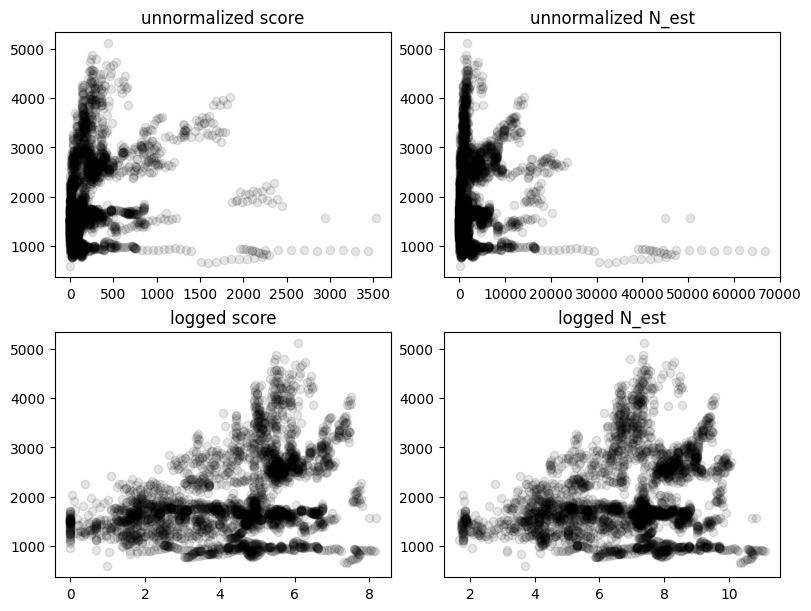

In [6]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8, 6), constrained_layout=True)
axes = axes.flatten()

axes[0].scatter(df["score"], df["gdp_per_capita"], alpha=0.1, color="k")
axes[0].set_title("unnormalized score")

axes[1].scatter(df["N_est"], df["gdp_per_capita"], alpha=0.1, color="k")
axes[1].set_title("unnormalized N_est")

axes[2].scatter(df["score_log"], df["gdp_per_capita"], alpha=0.1, color="k")
axes[2].set_title("logged score")

axes[3].scatter(df["N_est_log"], df["gdp_per_capita"], alpha=0.1, color="k")
axes[3].set_title("logged N_est");

## Regression Analysis: Setting a Baseline

In our attempt to model the relationship between per capita GDP and cultural production, we utilize linear regression models. By progressively developing more intricate models, we evaluate them via approximate leave-one-out cross-validation (LOO). Initially, we establish a global relationship model that doesn't account for any regional differentiation. The model is specified as follows:

\begin{align}
\log(\text{GDP}_i) & \sim \text{Normal}(\mu_i, \sigma) \\
\mu_i & = \alpha + \beta x_i \\
\alpha & \sim \text{Normal}(1, 1) \\
\beta & \sim \text{Normal}(0, 1) \\
\sigma & \sim \text{Exponential}(1)
\end{align} 

In this model, $\alpha$ stands for the intercept and $\beta$ denotes the coefficient of the production score.

In [7]:
models = {}

The model is easily translated to Bambi with:

In [8]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "sigma": bmb.Prior("Exponential", lam=1)
}

m_score = bmb.Model(
    f"log_gdp_std ~ score_log_std", df, family="gaussian", priors=priors)

The model graph looks as follows:

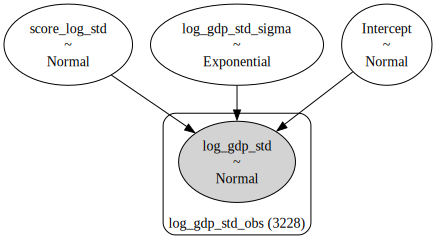

In [9]:
m_score.build()
m_score.graph()

Since this is a relatively simple model, we tune the sampler for 1000 timesteps and draw 1000 samples from the posterior:

In [10]:
fit_score = m_score.fit(draws=1000, chains=4, idata_kwargs={"log_likelihood": True})
models[f"gdp ~ score_log_std"] = fit_score

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_gdp_std_sigma, Intercept, score_log_std]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


A quick summary of the model wth ArViz indicates that globally, the cultural production score has small yet pronounced effect:

In [11]:
az.summary(models["gdp ~ score_log_std"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.957,0.002,0.953,0.962,0.0,0.0,6098.0,3152.0,1.0
score_log_std,0.043,0.002,0.038,0.047,0.0,0.0,6547.0,3281.0,1.0
log_gdp_std_sigma,0.052,0.001,0.050,0.053,0.0,0.0,5734.0,2843.0,1.0


However, the model fit is not particularly good. To further examine this, we conduct a posterior predictive check where we plot the estimated posterior against the observed GDP distribution. Evidently, the model falls short in fitting the trimodal structure of the data:

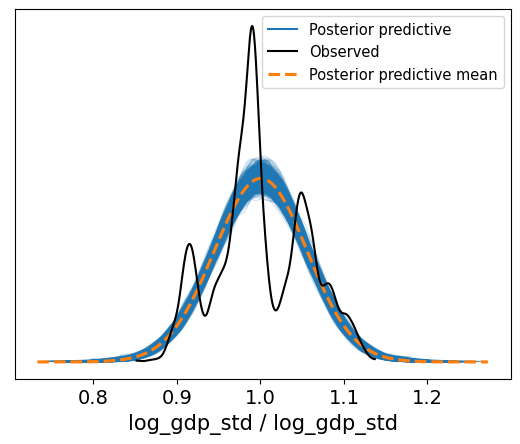

In [12]:
m_score.predict(fit_score, kind="pps")
az.plot_ppc(fit_score);

When we map the predictive posterior slopes against the empirical data in a scatter plot, it reaffirms our previous observation: the model is inadequate in accurately characterizing the data:

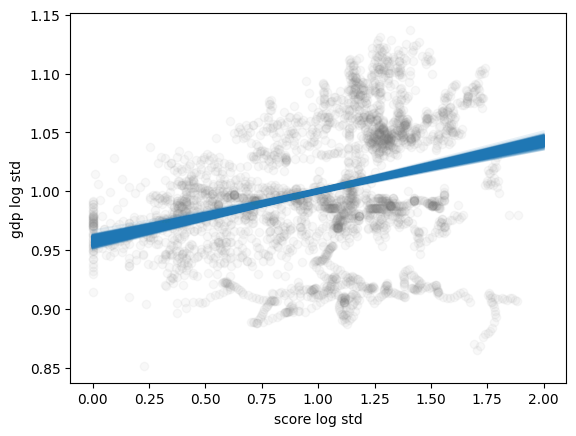

In [13]:
score_log_std_new = np.linspace(0, 2, num=200)
m_score.predict(fit_score, data=pd.DataFrame({"score_log_std": score_log_std_new}))
gdp = fit_score.posterior["log_gdp_std_mean"].sel(draw=slice(0, None, 5))

fig, ax = plt.subplots()
ax.plot(score_log_std_new, gdp.stack(samples=("chain", "draw")), color=f"C0", alpha=0.1)

ax.plot(df["score_log_std"], df["log_gdp_std"], 'o', color="grey", alpha=0.05, zorder=-5)
ax.set(xlabel="score log std", ylabel="gdp log std");

We juxtapose this model with another where we employ the bias-corrected cultural production score as opposed to the unnormalized score. While the model specification remains consistent, its implementation unfolds as follows:

In [14]:
m_est = bmb.Model(
    f"log_gdp_std ~ N_est_log_std", df, family="gaussian", priors=priors)
fit_est = m_est.fit(draws=1000, chains=4, idata_kwargs={"log_likelihood": True})
models[f"gdp ~ N_est_log_std"] = fit_est

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_gdp_std_sigma, Intercept, N_est_log_std]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


Similar to the previous analysis, a cursory analysis of the new model seems to suggest a slightly weaker but still positive correlation between the cultural production score and GDP:

In [15]:
az.summary(models["gdp ~ N_est_log_std"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.967,0.004,0.961,0.974,0.0,0.0,7680.0,3174.0,1.0
N_est_log_std,0.033,0.003,0.026,0.039,0.0,0.0,7597.0,3179.0,1.0
log_gdp_std_sigma,0.054,0.001,0.052,0.055,0.0,0.0,6988.0,3291.0,1.0


This relationship is visualized in the following graph:

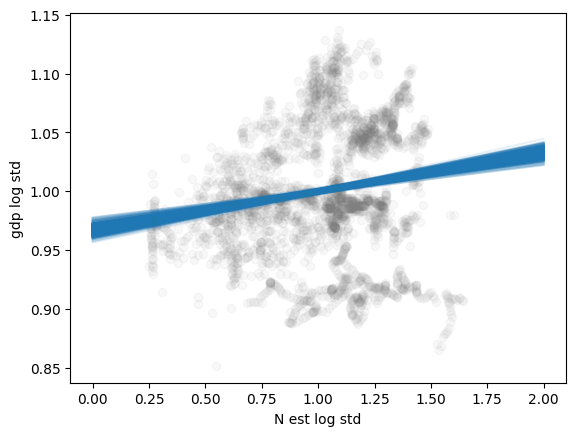

In [16]:
N_est_log_std_new = np.linspace(0, 2, num=200)
m_est.predict(fit_est, data=pd.DataFrame({"N_est_log_std": N_est_log_std_new}))
gdp = fit_est.posterior["log_gdp_std_mean"].sel(draw=slice(0, None, 5))

fig, ax = plt.subplots()
ax.plot(N_est_log_std_new, gdp.stack(samples=("chain", "draw")), color=f"C0", alpha=0.1)

ax.plot(df["N_est_log_std"], df["log_gdp_std"], 'o', color="grey", alpha=0.05, zorder=-5)
ax.set(xlabel="N est log std", ylabel="gdp log std");

However, as indicated by the posterior predictive check, the model fit continues to disappointingly underperform:

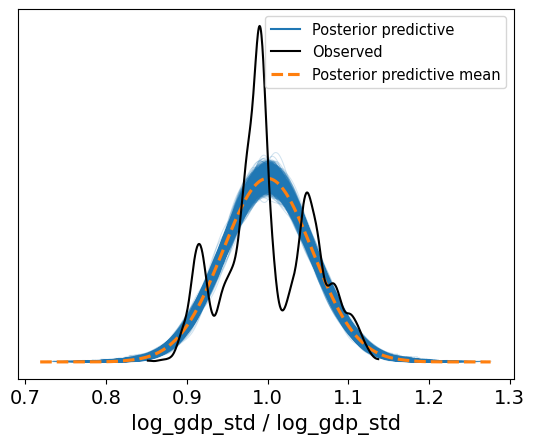

In [17]:
m_est.predict(fit_est, kind="pps")
az.plot_ppc(fit_est);

We utilize WAIC (Widely Applicable Information Criterion) or LOO to compare these models. This evaluation shows that the model incorporating the bias-corrected production variable does not perform better than one using the unnormalized variable. Nevertheless, as previously observed, both models exhibit subpar performance, suggesting caution in drawing any conclusions from this comparison. Overall, there appears evidence for a mildly positive relationship between the variables.

In [18]:
waic_compare = az.compare(models, ic='WAIC')
waic_compare

,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
gdp ~ score_log_std,0,4991.713589,2.708540,0.000000,1.000000e+00,37.704535,0.000000,False,log
gdp ~ N_est_log_std,1,4862.294717,2.574824,129.418873,6.901075e-10,35.909258,8.809211,False,log


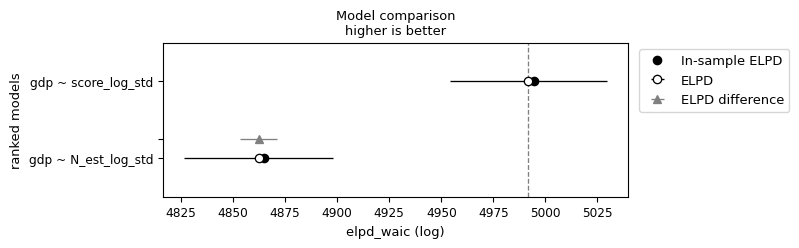

In [19]:
az.plot_compare(waic_compare, insample_dev=True);

## Hierarchical Linear Models

We now progress to a more nuanced analysis that leverages the inherent structure of our data, employing hierarchical linear models. Initially, we implement a rudimentary hierarchical model that only features varying intercepts for regions. This approach models each region as a distinct distribution, each contributing to the global intercept. The specification of the model is as follows:

\begin{align}
\log(\text{GDP}_i) & \sim \text{Normal}(\mu_i, \sigma) \\
\mu_i & = \alpha + \alpha_{\text{region}[i]}\\
\alpha_\text{region} & \sim \text{Normal}(0, \sigma_{\text{region}}) \\
\alpha & \sim \text{Normal}(1, 1) \\
\sigma_{\text{region}} & \sim \text{HalfNormal}(1) \\
\sigma & \sim \text{Exponential}(1)
\end{align} 

In [20]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "sigma": bmb.Prior("Exponential", lam=1)
}

m_vi = bmb.Model(
    "log_gdp_std ~ 1 + (1|region_name)", df, family="gaussian", noncentered=True, priors=priors)
m_vi

       Formula: log_gdp_std ~ 1 + (1|region_name)
        Family: gaussian
          Link: mu = identity
  Observations: 3228
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 1.0, sigma: 1.0)
        
        Group-level effects
            1|region_name ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
        
        Auxiliary parameters
            log_gdp_std_sigma ~ Exponential(lam: 1.0)

The model graph looks as follows:

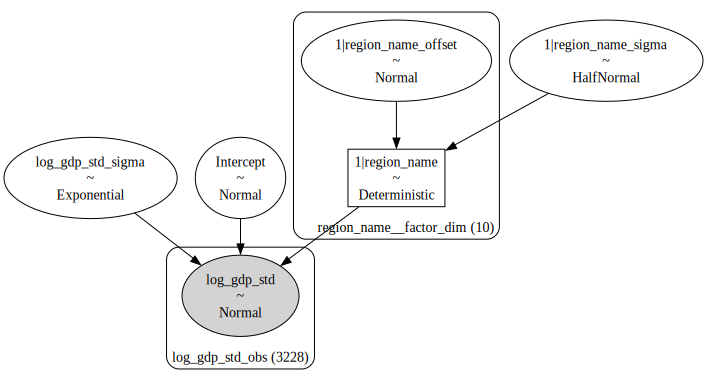

In [21]:
m_vi.build()
m_vi.graph()

The complexity of this model increases slightly, particularly due to the limited data points available for certain regions. Consequently, it's advisable to generate more posterior samples than in the previous models and proceed with a degree of caution while exploring the posterior during the sampling process:

In [22]:
m_vi_fit = m_vi.fit(
    draws=2000, 
    chains=4, 
    target_accept=0.9,  # more cautious exploration of the posterior
    idata_kwargs={"log_likelihood": True}
)
models["log_gdp_std ~ (1|region_name)"] = m_vi_fit
az.summary(m_vi_fit)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_gdp_std_sigma, Intercept, 1|region_name_sigma, 1|region_name_offset]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 56 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.981,0.019,0.944,1.018,0.001,0.0,1233.0,1820.0,1.0
log_gdp_std_sigma,0.026,0.000,0.026,0.027,0.000,0.0,4340.0,4294.0,1.0
1|region_name_sigma,0.058,0.017,0.032,0.089,0.000,0.0,1468.0,2275.0,1.0
1|region_name[Chinese world],-0.038,0.020,-0.075,0.000,0.001,0.0,1261.0,1961.0,1.0
1|region_name[Eastern Europe],-0.067,0.019,-0.104,-0.031,0.001,0.0,1232.0,1850.0,1.0
1|region_name[France],0.008,0.019,-0.028,0.046,0.001,0.0,1240.0,1823.0,1.0
1|region_name[German world],-0.002,0.021,-0.043,0.037,0.001,0.0,1390.0,2331.0,1.0
1|region_name[Italy],0.072,0.019,0.033,0.107,0.001,0.0,1238.0,1808.0,1.0
1|region_name[Japan],-0.059,0.021,-0.099,-0.021,0.001,0.0,1355.0,2128.0,1.0
1|region_name[Low countries],0.084,0.019,0.049,0.122,0.001,0.0,1238.0,1884.0,1.0


The sampling process appears to be effective, characterized by $\hat{r}$ scores hovering around 1 and a satisfactory effective sample size. Below, we provide a forest plot for the varying intercepts. Bear in mind that due to the construction of the model (non-centered), these intercepts should be interpreted as deviations from the global mean intercept, which is not displayed here.

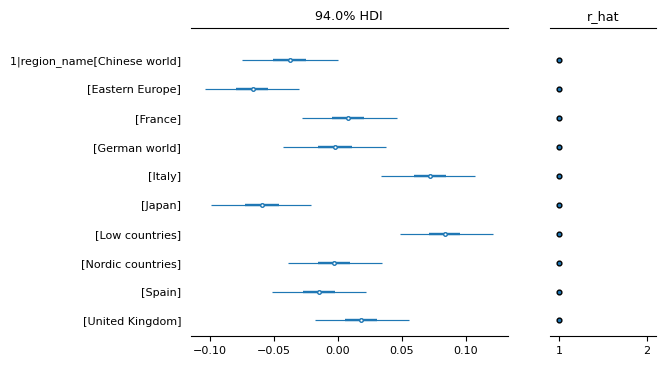

In [23]:
az.plot_forest(
    data=m_vi_fit, 
    figsize=(6, 4), 
    var_names=["1|region_name"], 
    r_hat=True, 
    combined=True, 
    textsize=8
);

Merely by incorporating the hierarchical levels associated with regions, we notice a significant improvement in the model fit, as illustrated in the subsequent posterior predictive check plot:

/Users/charlesdedampierre/Library/Caches/pypoetry/virtualenvs/market_use_cases-Q45SxFKl-py3.8/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/charlesdedampierre/Library/Caches/pypoetry/virtualenvs/market_use_cases-Q45SxFKl-py3.8/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


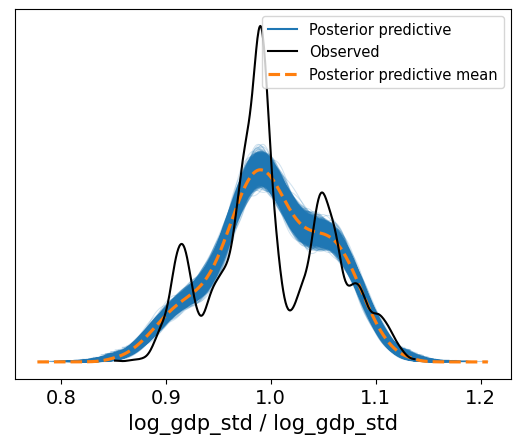

In [24]:
m_vi.predict(m_vi_fit, kind="pps")
az.plot_ppc(m_vi_fit);

### Varying Regions with Global Cultural Production Relationship

It thus seems that allowing variation in GDP per region is useful. We continue experimenting, adding the cultural production both regular and corrected to the model. The model description then becomes:

\begin{align*}
\log(\text{GDP}_i) & \sim \text{Normal}(\mu_i, \sigma) \\
\mu_i & = \alpha + \alpha_{\text{region}[i]} \beta x_i \\
\alpha_\text{region} & \sim \text{Normal}(0, \sigma_{\text{region}}) \\
\alpha & \sim \text{Normal}(1, 1) \\
\beta & \sim \text{Normal}(0, 1) \\
\sigma_{\text{region}} & \sim \text{HalfNormal}(1) \\
\sigma & \sim \text{Exponential}(1)
\end{align*} 

Note that this is essentially the model proposed in the current version of the paper without the variable time. However, including time as a linear predictor will not change the most important lessons of the models below.

In [25]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "sigma": bmb.Prior("Exponential", lam=1)
}

m_score_vi = bmb.Model(
    "log_gdp_std ~ score_log_std + (1|region_name)", 
    df, 
    family="gaussian", 
    noncentered=True, 
    priors=priors
)
m_score_vi

       Formula: log_gdp_std ~ score_log_std + (1|region_name)
        Family: gaussian
          Link: mu = identity
  Observations: 3228
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 1.0, sigma: 1.0)
            score_log_std ~ Normal(mu: 0.0, sigma: 1.0)
        
        Group-level effects
            1|region_name ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
        
        Auxiliary parameters
            log_gdp_std_sigma ~ Exponential(lam: 1.0)

The model graph looks as follows:

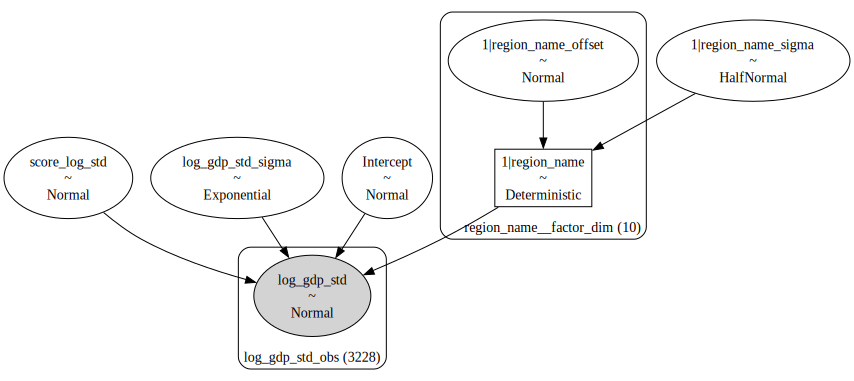

In [26]:
m_score_vi.build()
m_score_vi.graph()

In [27]:
m_score_vi_fit = m_score_vi.fit(
    draws=2000, 
    chains=4, 
    target_accept=0.9,
    idata_kwargs={"log_likelihood": True}
)
models["log_gdp_std ~ score_log_std + (1|region_name)"] = m_score_vi_fit
az.summary(m_score_vi_fit)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_gdp_std_sigma, Intercept, score_log_std, 1|region_name_sigma, 1|region_name_offset]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 98 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.947,0.018,0.913,0.981,0.001,0.0,1238.0,1713.0,1.0
score_log_std,0.035,0.001,0.033,0.037,0.000,0.0,6164.0,4737.0,1.0
log_gdp_std_sigma,0.023,0.000,0.022,0.024,0.000,0.0,6066.0,4632.0,1.0
1|region_name_sigma,0.056,0.016,0.032,0.086,0.000,0.0,1630.0,2739.0,1.0
1|region_name[Chinese world],-0.028,0.018,-0.064,0.006,0.001,0.0,1272.0,2003.0,1.0
1|region_name[Eastern Europe],-0.072,0.018,-0.106,-0.038,0.001,0.0,1240.0,1736.0,1.0
1|region_name[France],0.006,0.018,-0.028,0.041,0.001,0.0,1236.0,1768.0,1.0
1|region_name[German world],-0.023,0.020,-0.057,0.017,0.001,0.0,1399.0,2032.0,1.0
1|region_name[Italy],0.064,0.018,0.031,0.100,0.001,0.0,1233.0,1762.0,1.0
1|region_name[Japan],-0.048,0.019,-0.083,-0.012,0.001,0.0,1389.0,2117.0,1.0


Once again, the sampling appears to be successful, reflected by desirable $\hat{r}$ values and substantial effective sample sizes. The findings hint at a minimal positive global correlation between cultural production and GDP (0.035 CI [0.032, 0.037]). It seems that the model fit has experienced a slight enhancement

/Users/charlesdedampierre/Library/Caches/pypoetry/virtualenvs/market_use_cases-Q45SxFKl-py3.8/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/charlesdedampierre/Library/Caches/pypoetry/virtualenvs/market_use_cases-Q45SxFKl-py3.8/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


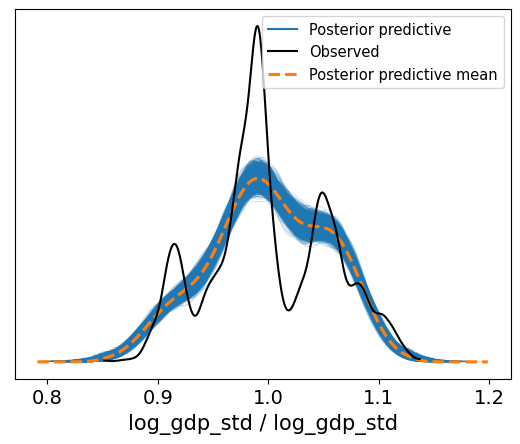

In [28]:
m_score_vi.predict(m_score_vi_fit, kind="pps")
az.plot_ppc(m_score_vi_fit);

Nevertheless, plotting the predictions against the observed data for each region provides more insightful information. This is depicted in the plot below, wherein it's evident that a global predictor of cultural production falls short in fitting the data accurately. Many regions, such as the Low Countries, the Chinese World, or Portugal, exhibit significant residuals, leaving a considerable amount of variation unexplained. Crucially, by assuming the relationship to be exclusively global, we imply it can only be unidirectional --- an assumption that, as we'll soon discover, may not necessarily hold true.

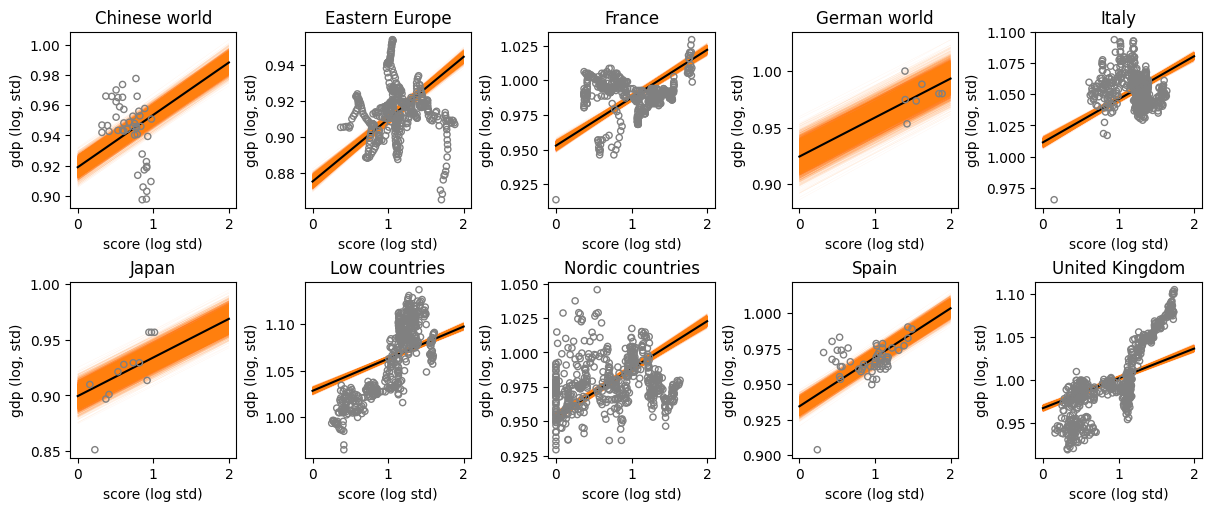

In [29]:
import xarray as xr

fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(12, 5), constrained_layout=True)
axes = axes.flatten()

for i, region_name in enumerate(df["region_name"].unique()):

    data_0 = df[df["region_name"] == region_name]

    posterior = az.extract(m_score_vi_fit)
    intercept_common = posterior["Intercept"]
    slope_common = posterior["score_log_std"]
    score = np.array([0, 2])

    intercept_specific_0 = posterior["1|region_name"].sel(region_name__factor_dim=region_name)
    a = (intercept_common + intercept_specific_0)
    b = slope_common

    score_xi = xr.DataArray(score)
    axes[i].plot(score_xi, (a + b * score_xi).T, color="C1", alpha=0.2, lw=0.1)
    axes[i].plot(score_xi, a.mean() + b.mean() * score_xi, color="black")
    axes[i].scatter(data_0["score_log_std"], data_0["log_gdp_std"], zorder=2, s=20, 
                    facecolors="none", edgecolors='grey')
    axes[i].set(ylabel="gdp (log, std)", xlabel="score (log std)", title=region_name)

Here's another visualization of the posterior predictions: the intercepts differ, but the slope (_by design_) is the same, and thus always positive:

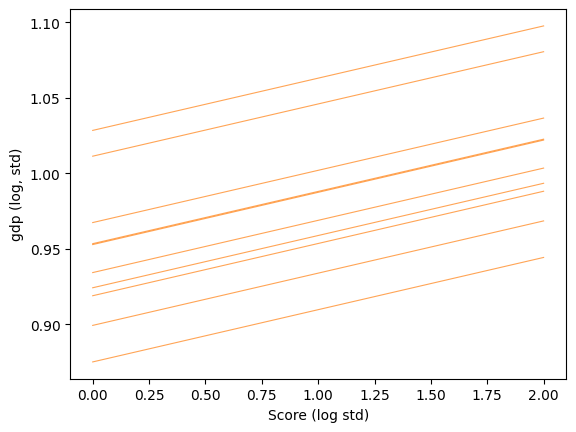

In [30]:
posterior = az.extract(m_score_vi_fit)
intercept_common = posterior["Intercept"]
slope_common = posterior["score_log_std"]
score = np.array([0, 2])

intercept_group_specific = posterior["1|region_name"]
a = intercept_common.mean() + intercept_group_specific.mean("sample")
b = slope_common.mean()
score_xi = xr.DataArray(score)
plt.plot(score_xi, (a + b * score_xi).T, color="C1", alpha=0.7, lw=0.8)
plt.ylabel("gdp (log, std)")
plt.xlabel("Score (log std)");

We perform the same analysis, swapping the cultural production score for the bias-corrected score:

In [31]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "sigma": bmb.Prior("Exponential", lam=1)
}

m_est_vi = bmb.Model(
    "log_gdp_std ~ N_est_log_std + (1|region_name)", 
    df, 
    family="gaussian", 
    noncentered=True,
    priors=priors)
m_est_vi

       Formula: log_gdp_std ~ N_est_log_std + (1|region_name)
        Family: gaussian
          Link: mu = identity
  Observations: 3228
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 1.0, sigma: 1.0)
            N_est_log_std ~ Normal(mu: 0.0, sigma: 1.0)
        
        Group-level effects
            1|region_name ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
        
        Auxiliary parameters
            log_gdp_std_sigma ~ Exponential(lam: 1.0)

In [32]:
m_est_vi_fit = m_est_vi.fit(
    draws=2000, 
    chains=4, 
    target_accept=0.9,
    idata_kwargs={"log_likelihood": True})

models["log_gdp_std ~ N_est_log_std + (1|region_name)"] = m_est_vi_fit
az.summary(m_est_vi_fit)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_gdp_std_sigma, Intercept, N_est_log_std, 1|region_name_sigma, 1|region_name_offset]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 101 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.937,0.019,0.902,0.973,0.001,0.0,1376.0,1915.0,1.0
N_est_log_std,0.044,0.002,0.041,0.047,0.000,0.0,5194.0,4698.0,1.0
log_gdp_std_sigma,0.024,0.000,0.023,0.025,0.000,0.0,5551.0,4336.0,1.0
1|region_name_sigma,0.058,0.017,0.032,0.088,0.000,0.0,1555.0,2287.0,1.0
1|region_name[Chinese world],-0.026,0.019,-0.060,0.011,0.000,0.0,1419.0,2198.0,1.0
1|region_name[Eastern Europe],-0.074,0.019,-0.109,-0.039,0.000,0.0,1390.0,2091.0,1.0
1|region_name[France],0.007,0.019,-0.026,0.044,0.000,0.0,1383.0,2047.0,1.0
1|region_name[German world],-0.022,0.020,-0.061,0.015,0.001,0.0,1600.0,2356.0,1.0
1|region_name[Italy],0.066,0.019,0.030,0.101,0.000,0.0,1390.0,2031.0,1.0
1|region_name[Japan],-0.049,0.020,-0.086,-0.012,0.001,0.0,1507.0,2213.0,1.0


The fit appears to bear similarity to the prior model, and once more, the incorporated unidirectional relationship yields comparatively large residuals.

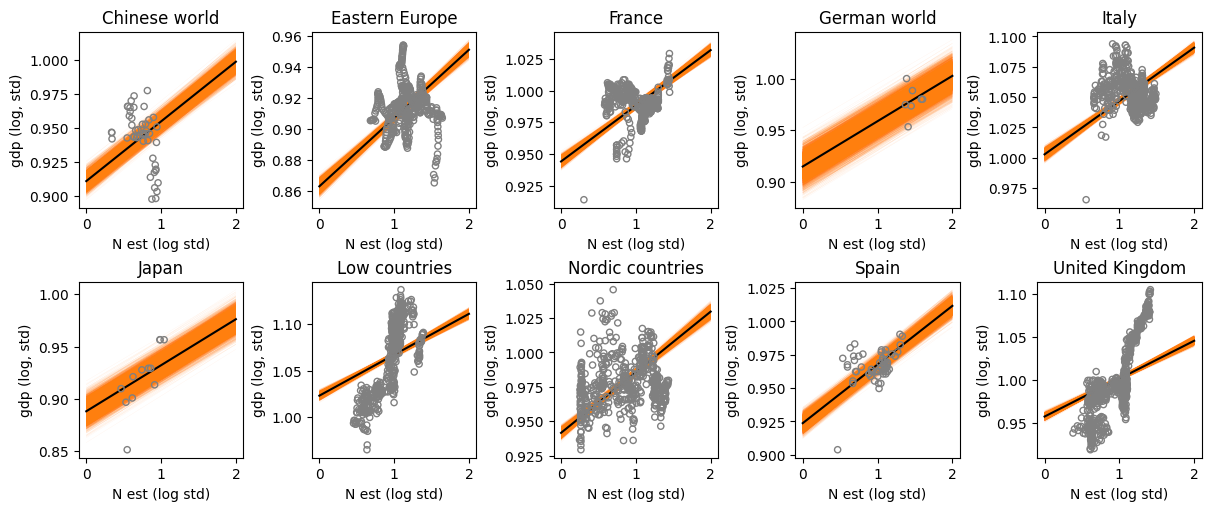

In [33]:
import xarray as xr

fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(12, 5), constrained_layout=True)
axes = axes.flatten()

for i, region_name in enumerate(df["region_name"].unique()):

    data_0 = df[df["region_name"] == region_name]

    posterior = az.extract(m_est_vi_fit)
    intercept_common = posterior["Intercept"]
    slope_common = posterior["N_est_log_std"]
    score = np.array([0, 2])

    intercept_specific_0 = posterior["1|region_name"].sel(region_name__factor_dim=region_name)
    a = (intercept_common + intercept_specific_0)
    b = slope_common

    score_xi = xr.DataArray(score)
    axes[i].plot(score_xi, (a + b * score_xi).T, color="C1", alpha=0.2, lw=0.1)
    axes[i].plot(score_xi, a.mean() + b.mean() * score_xi, color="black")
    axes[i].scatter(data_0["N_est_log_std"], data_0["log_gdp_std"], zorder=2, s=20, 
                    facecolors="none", edgecolors='grey')
    axes[i].set(ylabel="gdp (log, std)", xlabel="N est (log std)", title=region_name)

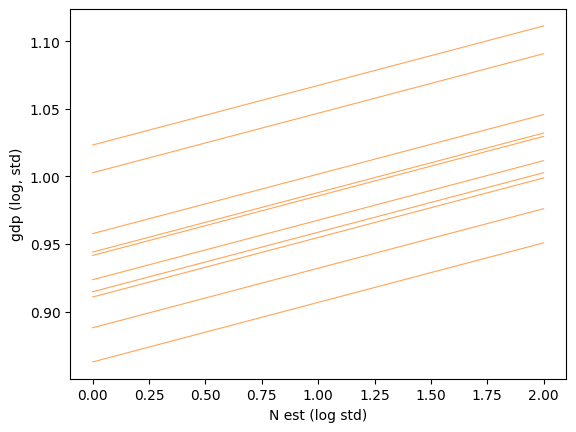

In [34]:
posterior = az.extract(m_est_vi_fit)
intercept_common = posterior["Intercept"]
slope_common = posterior["N_est_log_std"]
score = np.array([0, 2])

intercept_group_specific = posterior["1|region_name"]
a = intercept_common.mean() + intercept_group_specific.mean("sample")
b = slope_common.mean()
score_xi = xr.DataArray(score)
plt.plot(score_xi, (a + b * score_xi).T, color="C1", alpha=0.7, lw=0.8)
plt.ylabel("gdp (log, std)")
plt.xlabel("N est (log std)");

#### Model comparison

We undertake a comparison of all models explored thus far, this time employing approximate leave-one-out cross-validation (LOO). The model incorporating varying intercepts on region and using cultural score as a global predictor appears to best fit the data. As expected, it is closely followed by the model utilizing bias-corrected cultural production scores. All models featuring varying intercepts significantly outperform those with a singular global intercept. The results are demonstrated in the subsequent table and accompanying figure.

In [35]:
waic_compare = az.compare(models, ic='LOO')

In [36]:
waic_compare

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
log_gdp_std ~ score_log_std + (1|region_name),0,7589.422169,11.458873,0.000000,9.820996e-01,41.143275,0.000000,False,log
log_gdp_std ~ N_est_log_std + (1|region_name),1,7452.003217,11.231107,137.418952,2.075572e-08,43.800261,8.375182,False,log
log_gdp_std ~ (1|region_name),2,7146.527200,10.229738,442.894969,1.790040e-02,54.528302,30.091643,False,log
gdp ~ score_log_std,3,4991.710249,2.711880,2597.711920,3.313515e-08,37.704635,50.165910,False,log
gdp ~ N_est_log_std,4,4862.291425,2.578116,2727.130744,0.000000e+00,35.909345,48.117787,False,log


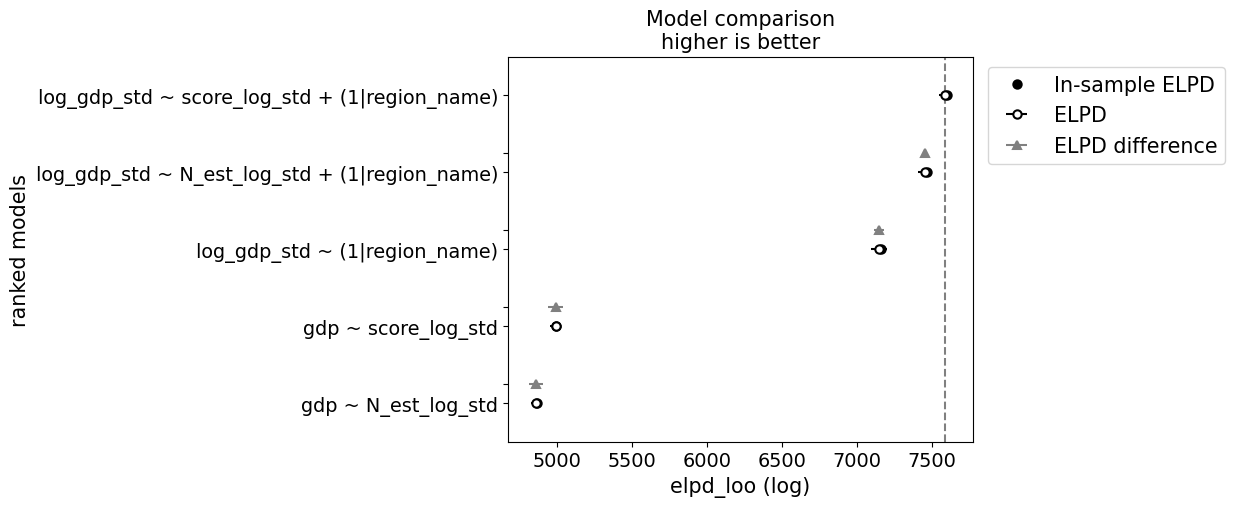

In [37]:
az.plot_compare(waic_compare, insample_dev=True);

/Users/charlesdedampierre/Library/Caches/pypoetry/virtualenvs/market_use_cases-Q45SxFKl-py3.8/lib/python3.8/site-packages/arviz/plots/compareplot.py:147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comp_df.sort_values(by="rank", inplace=True)


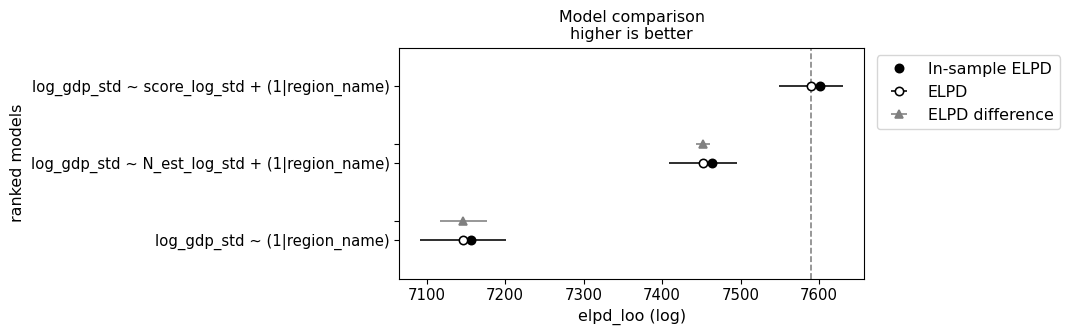

In [38]:
az.plot_compare(waic_compare.loc[waic_compare.index.str.contains("1|region_name")], insample_dev=True);

### Varying Slopes for Cultural Production in Different Regions

In our previous analysis, we presumed a global, uniform effect of cultural production on GDP per capita. However, upon observing significant discrepancies in the GDP intercepts per region, it's plausible that the relationship's slope between the cultural production score and GDP also varies. To cater to this, we construct a varying slope model with the following specification:

\begin{align*}
\log(\text{GDP}_i) & \sim \text{Normal}(\mu_i, \sigma) \\
\mu_i & = \alpha + \alpha_{\text{region}[i]} + (\beta + \beta_{\text{region}[i]}) x_i \\
\alpha_\text{region} & \sim \text{Normal}(0, \sigma_{\alpha}) \\
\beta_\text{region} & \sim \text{Normal}(0, \sigma_{\beta}) \\
\alpha & \sim \text{Normal}(1, 1) \\
\beta & \sim \text{Normal}(0, 1) \\
\sigma_{\alpha} & \sim \text{HalfNormal}(1) \\
\sigma_{\beta} & \sim \text{HalfNormal}(1) \\
\sigma & \sim \text{Exponential}(1)
\end{align*} 

As daunting as this might seem, it can be implemented relatively straightforward, as shown below. Also note that we could further improve the model by modeling the dependence of the priors on the varying slopes and intercepts. For now we treat them as independent priors, which may not be the most efficient way to do it.

In [39]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "score_log_std|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "sigma": bmb.Prior("Exponential", lam=1)
}

m_score_vs = bmb.Model(
    "log_gdp_std ~ score_log_std + (score_log_std|region_name)", 
    df, 
    family="gaussian", 
    noncentered=True,
    priors=priors
)
m_score_vs

       Formula: log_gdp_std ~ score_log_std + (score_log_std|region_name)
        Family: gaussian
          Link: mu = identity
  Observations: 3228
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 1.0, sigma: 1.0)
            score_log_std ~ Normal(mu: 0.0, sigma: 1.0)
        
        Group-level effects
            1|region_name ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
            score_log_std|region_name ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
        
        Auxiliary parameters
            log_gdp_std_sigma ~ Exponential(lam: 1.0)

The model graph looks as follows:

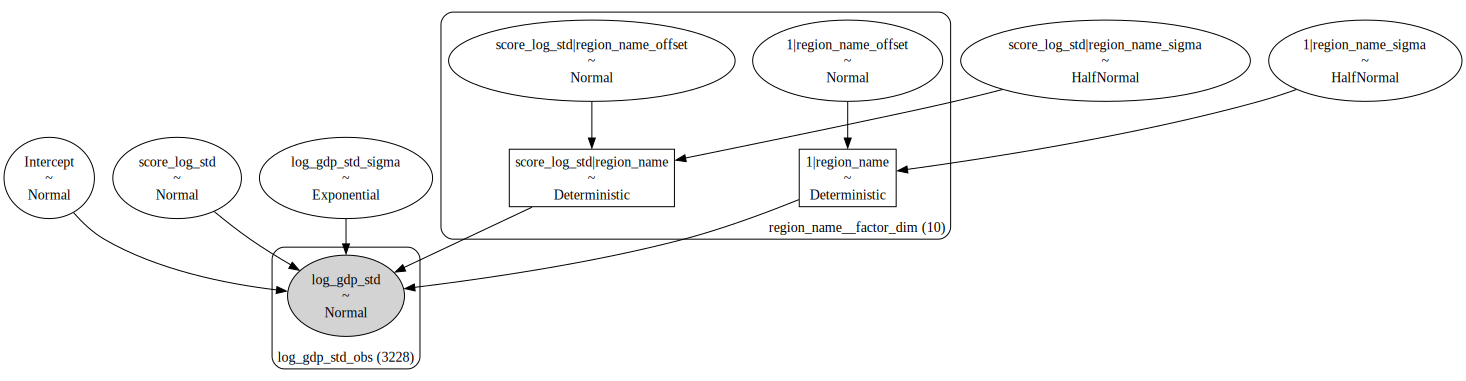

In [40]:
m_score_vs.build()
m_score_vs.graph()

Despite a considerable surge in the model's complexity, efficient sampling persists, marked by commendable $\hat{r}$ values and satisfactory effective sample sizes. The model's summary is provided below. A key observation we promptly make is the elimination of the unmistakably positive main, global effect of the cultural production score. Instead, it intersects 0 within the 97% confidence intervals, suggesting the effect is not solely positive. We'll elaborate on this further in the ensuing section.

In [41]:
m_score_vs_fit = m_score_vs.fit(
    draws=2000, 
    chains=4, 
    target_accept=0.9,
    idata_kwargs={"log_likelihood": True})

models["log_gdp_std ~ score_log_std + (score_log_std|region_name)"] = m_score_vs_fit
az.summary(m_score_vs_fit)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_gdp_std_sigma, Intercept, score_log_std, 1|region_name_sigma, 1|region_name_offset, score_log_std|region_name_sigma, score_log_std|region_name_offset]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 372 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.960,0.021,0.921,0.998,0.0,0.0,2737.0,3418.0,1.0
score_log_std,0.022,0.019,-0.015,0.055,0.0,0.0,2157.0,3107.0,1.0
log_gdp_std_sigma,0.017,0.000,0.017,0.017,0.0,0.0,9903.0,5389.0,1.0
1|region_name_sigma,0.061,0.019,0.032,0.094,0.0,0.0,2658.0,3436.0,1.0
score_log_std|region_name_sigma,0.056,0.018,0.030,0.088,0.0,0.0,2593.0,3747.0,1.0
1|region_name[Chinese world],0.021,0.022,-0.020,0.065,0.0,0.0,3071.0,3435.0,1.0
1|region_name[Eastern Europe],-0.042,0.021,-0.083,-0.005,0.0,0.0,2762.0,3572.0,1.0
1|region_name[France],0.026,0.021,-0.011,0.067,0.0,0.0,2748.0,3469.0,1.0
1|region_name[German world],-0.001,0.038,-0.067,0.075,0.0,0.0,6110.0,5202.0,1.0
1|region_name[Italy],0.104,0.021,0.065,0.144,0.0,0.0,2800.0,3271.0,1.0


Echoing our previous approach, we conduct a posterior predictive check and find that the model aligns with the data far more effectively. The difference with the simpler models is really remarkable:

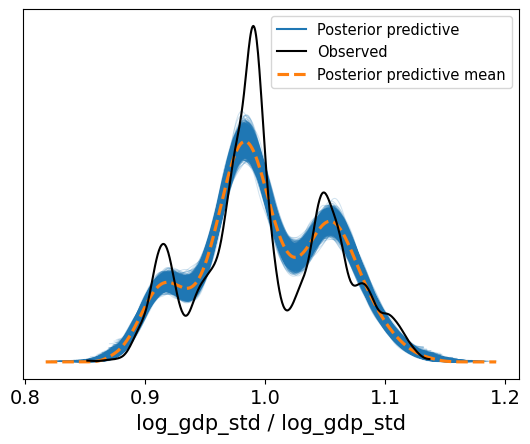

In [42]:
m_score_vs.predict(m_score_vs_fit, kind="pps")
az.plot_ppc(m_score_vs_fit);

The superior model fit becomes palpably apparent when we map the posterior predictions against the observations per region. In most instances, the varying slopes seem to align seamlessly with the data. A vital insight garnered from this plot is that the relationship between GDP and cultural production isn't universally positive across all regions. A pronounced positive correlation between the two variables is noticeable for the Low Countries, the United Kingdom, Japan, and to a slightly lesser degree, Spain. Conversely, the relationship appears inverted for the Chinese World, Eastern Europe, Italy, and the Arabic World. Portugal, France, and Central Europe do not appear to exhibit a distinct relationship, neither positive nor negative.

In [ ]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(12, 5), constrained_layout=True)
axes = axes.flatten()

for i, region_name in enumerate(df["region_name"].unique()):

    data_0 = df[df["region_name"] == region_name]

    posterior = az.extract(m_score_vs_fit)
    intercept_common = posterior["Intercept"]
    slope_common = posterior["score_log_std"]
    score = np.array([0, 2])

    intercept_specific_0 = posterior["1|region_name"].sel(region_name__factor_dim=region_name)
    slope_specific_0 = posterior["score_log_std|region_name"].sel(region_name__factor_dim=region_name)
    a = (intercept_common + intercept_specific_0)
    b = (slope_common + slope_specific_0)

    score_xi = xr.DataArray(score)
    axes[i].plot(score_xi, (a + b * score_xi).T, color="C1", alpha=0.2, lw=0.1)
    axes[i].plot(score_xi, a.mean() + b.mean() * score_xi, color="black")
    axes[i].scatter(data_0["score_log_std"], data_0["log_gdp_std"], zorder=2, s=20, 
                    facecolors="none", edgecolors='grey')
    axes[i].set(ylabel="gdp (log, std)", xlabel="score (log std)", title=region_name)

The ensuing plot illustrates the mean posterior distribution for each region, facilitating a more discernible understanding of regions that showcase a positive correlation between GDP and cultural production, and those that bear a negative or ambiguous relationship. The plot vividly indicates that some regions maintain a positive association, while others harbor a negative one. Thus, this analysis affirms that the incorporation of varying slopes in our model was justified and introduces valuable nuance to our exploration. **It underlines that we cannot unequivocally assert a positive correlation between cultural production and GDP, as this relationship varies by region.**

In [ ]:
from matplotlib.lines import Line2D

intercept_group_specific = posterior["1|region_name"]
slope_group_specific = posterior["score_log_std|region_name"]

a = intercept_common + intercept_group_specific
b = slope_common + slope_group_specific

score_xi = xr.DataArray(score)

fig, ax = plt.subplots()
for region in df["region_name"].unique():

    a_region = a.sel(region_name__factor_dim=region)
    b_region = b.sel(region_name__factor_dim=region)
    
    Y = (a_region + b_region * score_xi)
    Y_mean = Y.mean(axis=0)

    color = ("C0" if (Y[:, 1].quantile(0.025) > Y[:, 0].quantile(0.975)) else 
             "C1" if (Y[:, 0].quantile(0.025) > Y[:, 1].quantile(0.975)) else 
             "grey")
    ax.plot(score_xi, Y_mean, color=color, alpha=0.7, lw=0.8, label=region)
    ax.text(
        score_xi[-1],
        Y_mean[-1],
        " — " + region,
        size="small",
        color=color,
        ha="left",
        va="center",
    )
    
ax.spines[['right', 'top']].set_visible(False)
custom_lines = [Line2D([0], [0], color=c, lw=1) for c in ("C0", "C1", "grey")]
ax.legend(custom_lines, ['positive relationship', 'negative relationship', 'inconclusive relationship'], 
           loc="upper center", ncol=4, bbox_to_anchor=(0.5, 1.1), frameon=False)
ax.set(ylabel="gdp (log, std)", xlabel="score (log std)");

#### Covarying slopes and intercepts

To further scrutinize the region-specific slope attributes, we illustrate the covariance between region-specific intercepts and slopes. The hypothesis is the potential correlation between the intercepts and slopes, which may indicate, for instance, an enhanced or diminished GDP increase or decrease corresponding to higher or lower intercepts. The ensuing plot depicts this relationship. Although most regions don't seem to manifest a distinctly pronounced relationship between intercepts and slopes, there are a handful of intriguing cases where interaction is noticeable. For instance, in the German world, the Greek world, and in the Latin world, a negative correlation is observed, implying a decrease in slope as the intercept escalates. Contrarily, regions like the Low Countries, although having an average intercept (hence its position around zero), boast an above-average slope. On the other hand, the Chinese world, despite having an average intercept, showcases a below-average slope.

In [ ]:
import matplotlib

regions = df["region_name"].unique()

fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(12, 5), sharex=True, sharey=True, constrained_layout=True)

# #  extract a subsample from the posterior and stack the chain and draw dims
posterior = az.extract(m_score_vs_fit, num_samples=500)
for i, (region, ax) in enumerate(zip(regions, axes.flatten())):
    post = posterior.sel(region_name__factor_dim=region)
    X = post["1|region_name"].data
    Y = post["score_log_std|region_name"].data
    ax.scatter(
        X, Y,
        facecolor="C1", edgecolor="none", alpha=0.2)
    ax.set(title=region)

    ax.axhline(c="0.25", ls="--")
    ax.axvline(c="0.25", ls="--")
    
fig.supylabel('Region-specific slope')
fig.supxlabel('Region-specific intercept');
plt.savefig("covariance-plot.pdf")

Below, I repeat the analysis, again swapping cultural production for the bias-corrected score.

In [ ]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "N_est_log_std|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "sigma": bmb.Prior("Exponential", lam=1)
}

m_est_vs = bmb.Model(
    "log_gdp_std ~  N_est_log_std + (N_est_log_std|region_name)", 
    df, 
    family="gaussian", 
    noncentered=True,
    priors=priors
)
m_est_vs

In [ ]:
m_est_vs_fit = m_est_vs.fit(
    draws=2000, 
    chains=4, 
    target_accept=0.95,
    idata_kwargs={"log_likelihood": True})

models["log_gdp_std ~ N_est_log_std + (N_est_log_std|region_name)"] = m_est_vs_fit
az.summary(m_est_vs_fit)

# NB: hitting max_treedepth is not much of a concern, at least not for model validity
# For more information about this and other warnings, see https://mc-stan.org/misc/warnings.html
# TODO, see if we can improve efficiency

In [ ]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(12, 5), constrained_layout=True)
axes = axes.flatten()

for i, region_name in enumerate(df["region_name"].unique()):

    data_0 = df[df["region_name"] == region_name]

    posterior = az.extract(m_est_vs_fit)
    intercept_common = posterior["Intercept"]
    slope_common = posterior["N_est_log_std"]
    score = np.array([0, 2])

    intercept_specific_0 = posterior["1|region_name"].sel(region_name__factor_dim=region_name)
    slope_specific_0 = posterior["N_est_log_std|region_name"].sel(region_name__factor_dim=region_name)
    a = (intercept_common + intercept_specific_0)
    b = (slope_common + slope_specific_0)

    score_xi = xr.DataArray(score)
    axes[i].plot(score_xi, (a + b * score_xi).T, color="C1", alpha=0.2, lw=0.1)
    axes[i].plot(score_xi, a.mean() + b.mean() * score_xi, color="black")
    axes[i].scatter(data_0["N_est_log_std"], data_0["log_gdp_std"], zorder=2, s=20, 
                    facecolors="none", edgecolors='grey')
    axes[i].set(ylabel="gdp (log, std)", xlabel="N_est (log std)", title=region_name)

In [ ]:
from matplotlib.lines import Line2D

intercept_group_specific = posterior["1|region_name"]
slope_group_specific = posterior["N_est_log_std|region_name"]

a = intercept_common + intercept_group_specific
b = slope_common + slope_group_specific

score_xi = xr.DataArray(score)

fig, ax = plt.subplots()
for region in df["region_name"].unique():

    a_region = a.sel(region_name__factor_dim=region)
    b_region = b.sel(region_name__factor_dim=region)
    
    Y = (a_region + b_region * score_xi)
    Y_mean = Y.mean(axis=0)

    color = ("C0" if (Y[:, 1].quantile(0.025) > Y[:, 0].quantile(0.975)) else 
             "C1" if (Y[:, 0].quantile(0.025) > Y[:, 1].quantile(0.975)) else 
             "grey")
    ax.plot(score_xi, Y_mean, color=color, alpha=0.7, lw=0.8, label=region)
    ax.text(
        score_xi[-1],
        Y_mean[-1],
        " — " + region,
        size="small",
        color=color,
        ha="left",
        va="center",
    )
    
ax.spines[['right', 'top']].set_visible(False)
custom_lines = [Line2D([0], [0], color=c, lw=1) for c in ("C0", "C1", "grey")]
ax.legend(custom_lines, ['positive relationship', 'negative relationship', 'inconclusive relationship'], 
           loc="upper center", ncol=4, bbox_to_anchor=(0.5, 1.1), frameon=False)
ax.set(ylabel="gdp (log, std)", xlabel="N_est (log std)");

#### Model comparison

Finally, we execute a comparison across all models evaluated thus far. The comparison decisively underscores that incorporating varying slopes dramatically enhances the model fit, considerably outpacing the performance of the other models.

In [ ]:
waic_compare = az.compare(models, ic='LOO')
waic_compare

In [ ]:
az.plot_compare(waic_compare.loc[waic_compare.index.str.contains("region_name")], insample_dev=True);

# Cultural score per capita

In the analsyses above, we correlated a global cultural production score (both corrected and uncorrected) with the GDP scores per capita. These scores ignore differences in population size. As a final step in the analysis, we repeat the analyses with varying intercepts and varying slopes, but swapping the unnormalized cultural production scores for the scores per capita. We begin with the uncorrected score:

In [ ]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "sigma": bmb.Prior("Exponential", lam=1)
}

m_score_cap_vi = bmb.Model(
    "log_gdp_std ~ score_cap_log_std + (1|region_name)", 
    df, 
    family="gaussian", 
    noncentered=True, 
    priors=priors
)
m_score_cap_vi

The model graph looks as follows:

In [ ]:
m_score_cap_vi.build()
m_score_cap_vi.graph()

In [ ]:
m_score_cap_vi_fit = m_score_cap_vi.fit(
    draws=2000, 
    chains=4, 
    target_accept=0.9,
    idata_kwargs={"log_likelihood": True}
)
models["log_gdp_std ~ score_cap_log_std + (1|region_name)"] = m_score_cap_vi_fit
az.summary(m_score_cap_vi_fit)

Once again, the sampling appears to be successful, reflected by desirable $\hat{r}$ values and substantial effective sample sizes. The findings hint at a minimal positive global correlation between cultural production and GDP (0.023 CI [0.022, 0.025]). It seems that the model fit is decent. 

In [ ]:
m_score_cap_vi.predict(m_score_cap_vi_fit, kind="pps")
az.plot_ppc(m_score_cap_vi_fit);

In [ ]:
import xarray as xr

fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(12, 5), constrained_layout=True)
axes = axes.flatten()

for i, region_name in enumerate(df["region_name"].unique()):

    data_0 = df[df["region_name"] == region_name]

    posterior = az.extract(m_score_cap_vi_fit)
    intercept_common = posterior["Intercept"]
    slope_common = posterior["score_cap_log_std"]
    score = np.array([-1.5, 2])

    intercept_specific_0 = posterior["1|region_name"].sel(region_name__factor_dim=region_name)
    a = (intercept_common + intercept_specific_0)
    b = slope_common

    score_xi = xr.DataArray(score)
    axes[i].plot(score_xi, (a + b * score_xi).T, color="C1", alpha=0.2, lw=0.1)
    axes[i].plot(score_xi, a.mean() + b.mean() * score_xi, color="black")
    axes[i].scatter(data_0["score_cap_log_std"], data_0["log_gdp_std"], zorder=2, s=20, 
                    facecolors="none", edgecolors='grey')
    axes[i].set(ylabel="gdp (log, std)", xlabel="score per capita (log std)", title=region_name)

Here's another visualization of the posterior predictions: the intercepts differ, but the slope (_by design_) is the same, and thus always positive:

In [ ]:
posterior = az.extract(m_score_cap_vi_fit)
intercept_common = posterior["Intercept"]
slope_common = posterior["score_cap_log_std"]
score = np.array([-1.5, 2])

intercept_group_specific = posterior["1|region_name"]
a = intercept_common.mean() + intercept_group_specific.mean("sample")
b = slope_common.mean()
score_xi = xr.DataArray(score)
plt.plot(score_xi, (a + b * score_xi).T, color="C1", alpha=0.7, lw=0.8)
plt.ylabel("gdp (log, std)")
plt.xlabel("Score per capita (log std)");

We perform the same analysis, swapping the cultural production score for the bias-corrected score:

In [ ]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "sigma": bmb.Prior("Exponential", lam=1)
}

m_est_cap_vi = bmb.Model(
    "log_gdp_std ~ N_est_cap_log_std + (1|region_name)", 
    df, 
    family="gaussian", 
    noncentered=True,
    priors=priors)
m_est_cap_vi

In [ ]:
m_est_cap_vi_fit = m_est_cap_vi.fit(
    draws=2000, 
    chains=4, 
    target_accept=0.9,
    idata_kwargs={"log_likelihood": True})

models["log_gdp_std ~ N_est_cap_log_std + (1|region_name)"] = m_est_cap_vi_fit
az.summary(m_est_cap_vi_fit)

The fit appears to bear similarity to the prior model, and once more, the incorporated unidirectional relationship yields comparatively large residuals.

In [ ]:
import xarray as xr

fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(12, 5), constrained_layout=True)
axes = axes.flatten()

for i, region_name in enumerate(df["region_name"].unique()):

    data_0 = df[df["region_name"] == region_name]

    posterior = az.extract(m_est_cap_vi_fit)
    intercept_common = posterior["Intercept"]
    slope_common = posterior["N_est_cap_log_std"]
    score = np.array([-1.5, 2])

    intercept_specific_0 = posterior["1|region_name"].sel(region_name__factor_dim=region_name)
    a = (intercept_common + intercept_specific_0)
    b = slope_common

    score_xi = xr.DataArray(score)
    axes[i].plot(score_xi, (a + b * score_xi).T, color="C1", alpha=0.2, lw=0.1)
    axes[i].plot(score_xi, a.mean() + b.mean() * score_xi, color="black")
    axes[i].scatter(data_0["N_est_cap_log_std"], data_0["log_gdp_std"], zorder=2, s=20, 
                    facecolors="none", edgecolors='grey')
    axes[i].set(ylabel="gdp (log, std)", xlabel="N est per capita (log std)", title=region_name)

In [ ]:
posterior = az.extract(m_est_cap_vi_fit)
intercept_common = posterior["Intercept"]
slope_common = posterior["N_est_cap_log_std"]
score = np.array([-1.5, 2])

intercept_group_specific = posterior["1|region_name"]
a = intercept_common.mean() + intercept_group_specific.mean("sample")
b = slope_common.mean()
score_xi = xr.DataArray(score)
plt.plot(score_xi, (a + b * score_xi).T, color="C1", alpha=0.7, lw=0.8)
plt.ylabel("gdp (log, std)")
plt.xlabel("N est per capita (log std)");

### Varying Slopes for Cultural Production in Different Regions

In [ ]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "score_cap_log_std|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "sigma": bmb.Prior("Exponential", lam=1)
}

m_score_cap_vs = bmb.Model(
    "log_gdp_std ~ score_cap_log_std + (score_cap_log_std|region_name)", 
    df, 
    family="gaussian", 
    noncentered=True,
    priors=priors
)
m_score_cap_vs

The model graph looks as follows:

In [ ]:
m_score_cap_vs.build()
m_score_cap_vs.graph()

In [ ]:
m_score_cap_vs_fit = m_score_cap_vs.fit(
    draws=2000, 
    chains=4, 
    target_accept=0.9,
    idata_kwargs={"log_likelihood": True})

models["log_gdp_std ~ score_cap_log_std + (score_cap_log_std|region_name)"] = m_score_cap_vs_fit
az.summary(m_score_cap_vs_fit)

Echoing our previous approach, we conduct a posterior predictive check and find that the model aligns with the data far more effectively. The difference with the simpler models is really remarkable:

In [ ]:
m_score_cap_vs.predict(m_score_cap_vs_fit, kind="pps")
az.plot_ppc(m_score_cap_vs_fit);

In [ ]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(12, 5), constrained_layout=True)
axes = axes.flatten()

for i, region_name in enumerate(df["region_name"].unique()):

    data_0 = df[df["region_name"] == region_name]

    posterior = az.extract(m_score_cap_vs_fit)
    intercept_common = posterior["Intercept"]
    slope_common = posterior["score_cap_log_std"]
    score = np.array([-1.5, 2])

    intercept_specific_0 = posterior["1|region_name"].sel(region_name__factor_dim=region_name)
    slope_specific_0 = posterior["score_cap_log_std|region_name"].sel(region_name__factor_dim=region_name)
    a = (intercept_common + intercept_specific_0)
    b = (slope_common + slope_specific_0)

    score_xi = xr.DataArray(score)
    axes[i].plot(score_xi, (a + b * score_xi).T, color="C1", alpha=0.2, lw=0.1)
    axes[i].plot(score_xi, a.mean() + b.mean() * score_xi, color="black")
    axes[i].scatter(data_0["score_cap_log_std"], data_0["log_gdp_std"], zorder=2, s=20, 
                    facecolors="none", edgecolors='grey')
    axes[i].set(ylabel="gdp (log, std)", xlabel="score per capita (log std)", title=region_name)

In [ ]:
from matplotlib.lines import Line2D

intercept_group_specific = posterior["1|region_name"]
slope_group_specific = posterior["score_cap_log_std|region_name"]

a = intercept_common + intercept_group_specific
b = slope_common + slope_group_specific

score_xi = xr.DataArray(score)

fig, ax = plt.subplots()
for region in df["region_name"].unique():

    a_region = a.sel(region_name__factor_dim=region)
    b_region = b.sel(region_name__factor_dim=region)
    
    Y = (a_region + b_region * score_xi)
    Y_mean = Y.mean(axis=0)

    color = ("C0" if (Y[:, 1].quantile(0.025) > Y[:, 0].quantile(0.975)) else 
             "C1" if (Y[:, 0].quantile(0.025) > Y[:, 1].quantile(0.975)) else 
             "grey")
    ax.plot(score_xi, Y_mean, color=color, alpha=0.7, lw=0.8, label=region)
    ax.text(
        score_xi[-1],
        Y_mean[-1],
        " — " + region,
        size="small",
        color=color,
        ha="left",
        va="center",
    )
    
ax.spines[['right', 'top']].set_visible(False)
custom_lines = [Line2D([0], [0], color=c, lw=1) for c in ("C0", "C1", "grey")]
ax.legend(custom_lines, ['positive relationship', 'negative relationship', 'inconclusive relationship'], 
           loc="upper center", ncol=4, bbox_to_anchor=(0.5, 1.1), frameon=False)
ax.set(ylabel="gdp (log, std)", xlabel="score per capita (log std)");

Below, I repeat the analysis, again swapping cultural production for the bias-corrected score.

In [ ]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "N_est_cap_log_std|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "sigma": bmb.Prior("Exponential", lam=1)
}

m_est_cap_vs = bmb.Model(
    "log_gdp_std ~  N_est_cap_log_std + (N_est_cap_log_std|region_name)", 
    df, 
    family="gaussian", 
    noncentered=True,
    priors=priors
)
m_est_cap_vs

In [ ]:
m_est_cap_vs_fit = m_est_cap_vs.fit(
    draws=2000, 
    chains=4, 
    target_accept=0.95,
    idata_kwargs={"log_likelihood": True})

models["log_gdp_std ~ N_est_cap_log_std + (N_est_cap_log_std|region_name)"] = m_est_cap_vs_fit
az.summary(m_est_cap_vs_fit)

# NB: hitting max_treedepth is not much of a concern, at least not for model validity
# For more information about this and other warnings, see https://mc-stan.org/misc/warnings.html
# TODO, see if we can improve efficiency

In [ ]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(12, 5), constrained_layout=True)
axes = axes.flatten()

for i, region_name in enumerate(df["region_name"].unique()):

    data_0 = df[df["region_name"] == region_name]

    posterior = az.extract(m_est_cap_vs_fit)
    intercept_common = posterior["Intercept"]
    slope_common = posterior["N_est_cap_log_std"]
    score = np.array([-1.5, 2])

    intercept_specific_0 = posterior["1|region_name"].sel(region_name__factor_dim=region_name)
    slope_specific_0 = posterior["N_est_cap_log_std|region_name"].sel(region_name__factor_dim=region_name)
    a = (intercept_common + intercept_specific_0)
    b = (slope_common + slope_specific_0)

    score_xi = xr.DataArray(score)
    axes[i].plot(score_xi, (a + b * score_xi).T, color="C1", alpha=0.2, lw=0.1)
    axes[i].plot(score_xi, a.mean() + b.mean() * score_xi, color="black")
    axes[i].scatter(data_0["N_est_cap_log_std"], data_0["log_gdp_std"], zorder=2, s=20, 
                    facecolors="none", edgecolors='grey')
    axes[i].set(ylabel="gdp (log, std)", xlabel="N_est per capita (log std)", title=region_name)

In [ ]:
from matplotlib.lines import Line2D

intercept_group_specific = posterior["1|region_name"]
slope_group_specific = posterior["N_est_cap_log_std|region_name"]

a = intercept_common + intercept_group_specific
b = slope_common + slope_group_specific

score_xi = xr.DataArray(score)

fig, ax = plt.subplots()
for region in df["region_name"].unique():

    a_region = a.sel(region_name__factor_dim=region)
    b_region = b.sel(region_name__factor_dim=region)
    
    Y = (a_region + b_region * score_xi)
    Y_mean = Y.mean(axis=0)

    color = ("C0" if (Y[:, 1].quantile(0.025) > Y[:, 0].quantile(0.975)) else 
             "C1" if (Y[:, 0].quantile(0.025) > Y[:, 1].quantile(0.975)) else 
             "grey")
    ax.plot(score_xi, Y_mean, color=color, alpha=0.7, lw=0.8, label=region)
    ax.text(
        score_xi[-1],
        Y_mean[-1],
        " — " + region,
        size="small",
        color=color,
        ha="left",
        va="center",
    )
    
ax.spines[['right', 'top']].set_visible(False)
custom_lines = [Line2D([0], [0], color=c, lw=1) for c in ("C0", "C1", "grey")]
ax.legend(custom_lines, ['positive relationship', 'negative relationship', 'inconclusive relationship'], 
           loc="upper center", ncol=4, bbox_to_anchor=(0.5, 1.1), frameon=False)
ax.set(ylabel="gdp (log, std)", xlabel="N_est per capita (log std)");

#### Model comparison

Finally, we execute a comparison across all models evaluated thus far. The comparison decisively underscores that incorporating varying slopes dramatically enhances the model fit, considerably outpacing the performance of the other models. Furthermore, we note that the bias-correction does not improve the model fit considerably. Finally, representing the cultural scores per capita does not improve the model fit either. 

In [ ]:
waic_compare = az.compare(models, ic='LOO')
waic_compare

In [ ]:
az.plot_compare(waic_compare.loc[waic_compare.index.str.contains("region_name")], insample_dev=True);